In [33]:
import pandas as pd
import numpy as np
import pickle
#import random
from pathlib import Path

#from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, SCORERS

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
import warnings
warnings.filterwarnings('ignore')

## Функции

### Reports

In [35]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [36]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [37]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [38]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 9)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [39]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Tranforms and features

In [40]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [41]:
def fill_means(df, list):
  for i in range(len(list)):
    df[list[i]].fillna(df[list[i]].mean(), inplace=True)
  print(f"Значения NA заменены средними по колонке ")
  return df

In [42]:
def fill_dummies (df, list):
  for i in range(len(list)):
    df = pd.concat([df, pd.get_dummies(df[list[i]])], axis=1)
  df.drop(columns=CAT_FEATURE_NAMES, inplace=True)
  print(f"Категориальные признаки разложены на dummy значения и удалены из df")
  return df

## **Пути к директориям и файлам**

In [43]:
from pathlib import Path

%cd C:\Users\Denis\Google Диск\Colab Notebooks\Python libs Part 2
DATA_ROOT = Path('./course_project/')
MODELS_PATH = Path('./models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'course_project_train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'course_project_test.csv'

# output
SUBMISSON_DATASET_PATH = DATA_ROOT / 'SUBMISSON.csv'


C:\Users\Denis\Google Диск\Colab Notebooks\Python libs Part 2


**Описание датасета**

*   Home Ownership - домовладение
*   Annual Income - годовой доход
*   Years in current job - количество лет на текущем месте работы
*   Tax Liens - налоговые обременения
*   Number of Open Accounts - количество открытых счетов
*   Years of Credit History - количество лет кредитной истории
*   Maximum Open Credit - наибольший открытый кредит
*   Number of Credit Problems - количество проблем с кредитом
*   Months since last delinquent - количество месяцев с последней просрочки платежа
*   Bankruptcies - банкротства
*   Purpose - цель кредита
*   Term - срок кредита
*   Current Loan Amount - текущая сумма кредита
*   Current Credit Balance - текущий кредитный баланс
*   Monthly Debt - ежемесячный долг
*   Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)





## Оптимизируем память

In [44]:
# оптимизируем память
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [45]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

df = reduce_mem_usage(df)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


## **Выделение целевой переменной и групп признаков**

In [46]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [47]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [48]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Number of Credit Problems', 'Years of Credit History',  'Maximum Open Credit', 
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

## EDA

In [49]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [50]:
df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

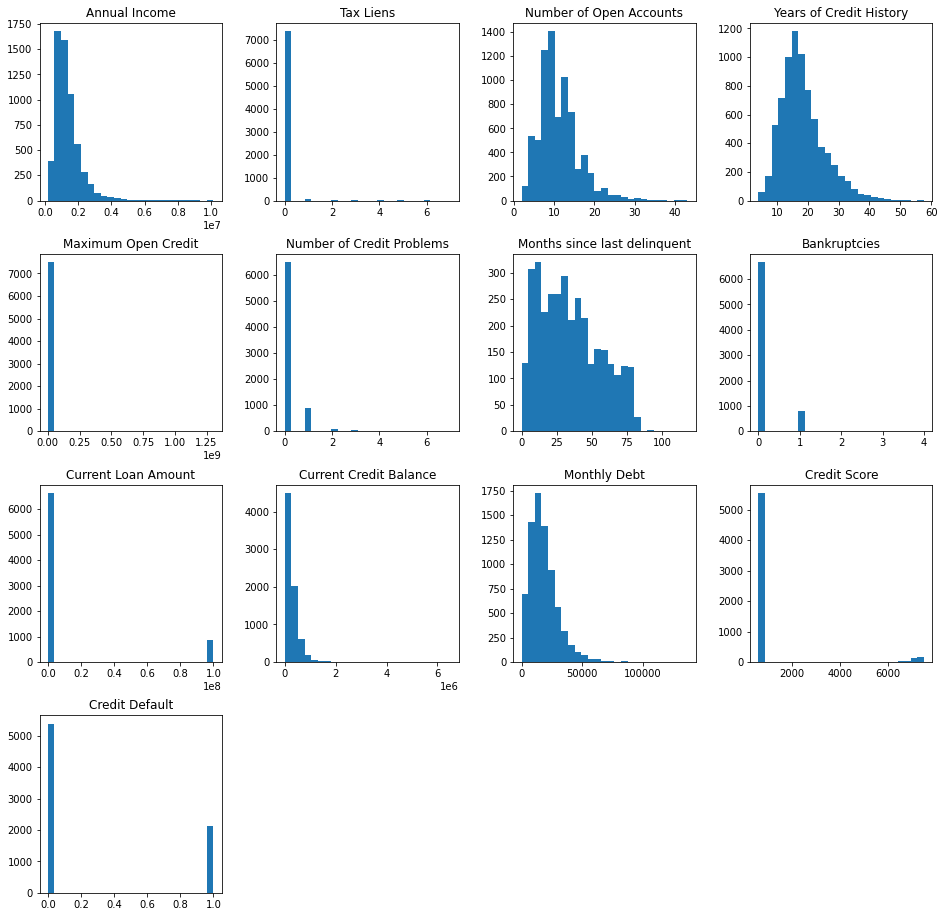

In [51]:
# проверяем распределение признаков
df.hist(figsize=(16,16), bins=25, grid=False);

### Заполняем пропуски

In [52]:
for col in df.columns: 
    count_na = df[col].isna().value_counts(normalize=True)
    if count_na[0] != 1:
      print(f"{count_na}")

False    0.7924
True     0.2076
Name: Annual Income, dtype: float64
False    0.950533
True     0.049467
Name: Years in current job, dtype: float64
True     0.544133
False    0.455867
Name: Months since last delinquent, dtype: float64
False    0.998133
True     0.001867
Name: Bankruptcies, dtype: float64
False    0.7924
True     0.2076
Name: Credit Score, dtype: float64


In [53]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [54]:
NUM_FEATURE_NAMES_WITH_PASS = ['Annual Income', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']

In [55]:
df = fill_means (df, NUM_FEATURE_NAMES_WITH_PASS)

Значения NA заменены средними по колонке 


Дескритизация категориальных признаков

In [56]:
df[CAT_FEATURE_NAMES].value_counts

<bound method DataFrame.value_counts of      Home Ownership Years in current job             Purpose        Term
0          Own Home                  NaN  debt consolidation  Short Term
1          Own Home            10+ years  debt consolidation   Long Term
2     Home Mortgage              8 years  debt consolidation  Short Term
3          Own Home              6 years  debt consolidation  Short Term
4              Rent              8 years  debt consolidation  Short Term
...             ...                  ...                 ...         ...
7495           Rent             < 1 year               other  Short Term
7496  Home Mortgage               1 year  debt consolidation   Long Term
7497           Rent              6 years           buy a car  Short Term
7498  Home Mortgage                  NaN  debt consolidation  Short Term
7499           Rent              4 years  debt consolidation  Short Term

[7500 rows x 4 columns]>

In [57]:
pd.get_dummies(df['Term']).sample(5)

,Long Term,Short Term
815,0,1
6322,0,1
4463,0,1
642,0,1
4796,1,0


In [58]:
df = fill_dummies(df, CAT_FEATURE_NAMES)

Категориальные признаки разложены на dummy значения и удалены из df


### Балансировка данных

In [59]:
df = balance_df_by_target(df, TARGET_NAME, method='tomek')

## Разбиение на train и valid

In [60]:
X = df.drop(columns=TARGET_NAME)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.20,
                                                    random_state=13
                                                    )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.687813
1    0.312187
Name: Credit Default, dtype: float64

0    0.681009
1    0.318991
Name: Credit Default, dtype: float64

## Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [61]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      3708
           1       0.75      0.24      0.36      1683

    accuracy                           0.74      5391
   macro avg       0.74      0.60      0.60      5391
weighted avg       0.74      0.74      0.69      5391

TEST

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       918
           1       0.76      0.26      0.38       430

    accuracy                           0.74      1348
   macro avg       0.75      0.61      0.61      1348
weighted avg       0.74      0.74      0.69      1348

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               883   35
1               320  110


**Дерево решений**

In [62]:
model_tree = DecisionTreeClassifier(random_state=13,
                                    class_weight={0:1, 1:2},
                                    max_depth=4
                                    )
# model_tree.fit(X_train, y_train)
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      3708
           1       0.66      0.43      0.53      1683

    accuracy                           0.75      5391
   macro avg       0.72      0.67      0.68      5391
weighted avg       0.74      0.75      0.74      5391

TEST

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       918
           1       0.67      0.42      0.51       430

    accuracy                           0.75      1348
   macro avg       0.72      0.66      0.67      1348
weighted avg       0.74      0.75      0.73      1348

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               828   90
1               250  180


CatBoostClassifier

In [63]:
model_cat = catb.CatBoostClassifier(n_estimators=150, max_depth=5,
                                      l2_leaf_reg=10,
                                      class_weights=[1, 2],
                                      silent=True, random_state=13)
model_cat.fit(X_train, y_train)

y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)
y_test_pred_probs = model_cat.predict_proba(X_test)

evaluate_preds(model_cat, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3708
           1       0.63      0.61      0.62      1683

    accuracy                           0.76      5391
   macro avg       0.73      0.72      0.72      5391
weighted avg       0.76      0.76      0.76      5391

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       918
           1       0.58      0.59      0.58       430

    accuracy                           0.73      1348
   macro avg       0.69      0.69      0.69      1348
weighted avg       0.73      0.73      0.73      1348

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               738  180
1               178  252


### Подбираем оптимальные параметры

In [64]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [65]:
params = {'n_estimators':[500], 
          'max_depth':[6, 7, 8],
          'l2_leaf_reg':[10, 15]}

model_cat = GridSearchCV(model_cat, params, 
                  scoring='f1_macro' , # метрика 
                  cv=KFold(n_splits=7,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=13, 
                           shuffle=True),
                  n_jobs=15
                  )

In [34]:
# %%time
# model_cat.fit(X_train, y_train)
# model_cat.best_params_

In [66]:
model_cat.best_params_={'l2_leaf_reg': 10, 'max_depth': 6, 'n_estimators': 500}
# model_cat.best_params_={'l2_leaf_reg': 15, 'max_depth': 12, 'n_estimators': 500}

In [67]:
model_cat = catb.CatBoostClassifier(n_estimators=model_cat.best_params_.get('n_estimators'), 
                                    max_depth=model_cat.best_params_.get('max_depth'),
                                    l2_leaf_reg=model_cat.best_params_.get('l2_leaf_reg'),
                                    class_weights=[1, 2],
                                    silent=True, random_state=13)
model_cat.fit(X_train, y_train)

y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)
y_test_pred_probs = model_cat.predict_proba(X_test)

evaluate_preds(model_cat, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3708
           1       0.72      0.79      0.75      1683

    accuracy                           0.84      5391
   macro avg       0.81      0.82      0.82      5391
weighted avg       0.84      0.84      0.84      5391

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       918
           1       0.58      0.62      0.60       430

    accuracy                           0.74      1348
   macro avg       0.70      0.71      0.70      1348
weighted avg       0.74      0.74      0.74      1348

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               730  188
1               165  265


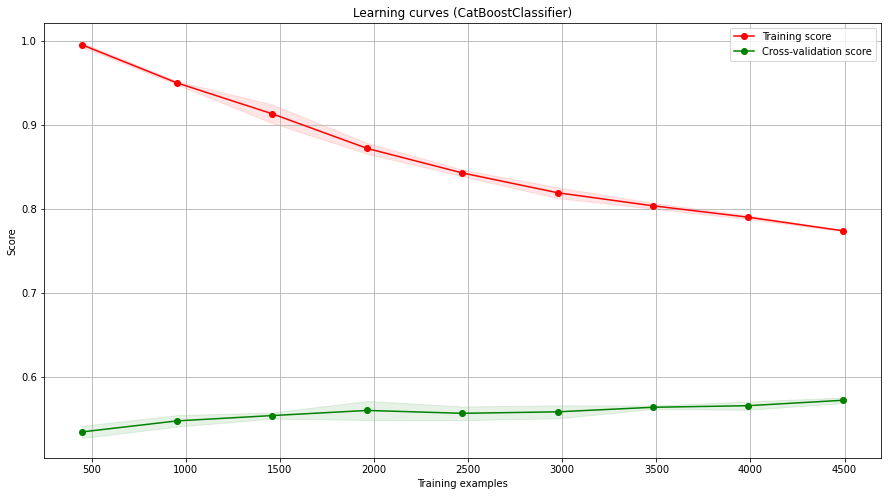

In [68]:
show_learning_curve_plot(model_cat, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

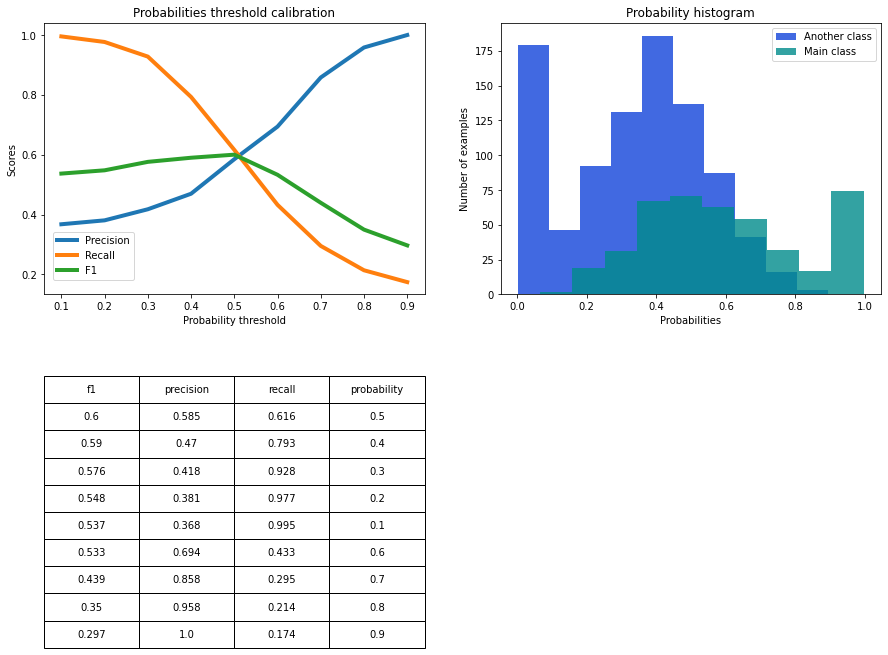

In [69]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

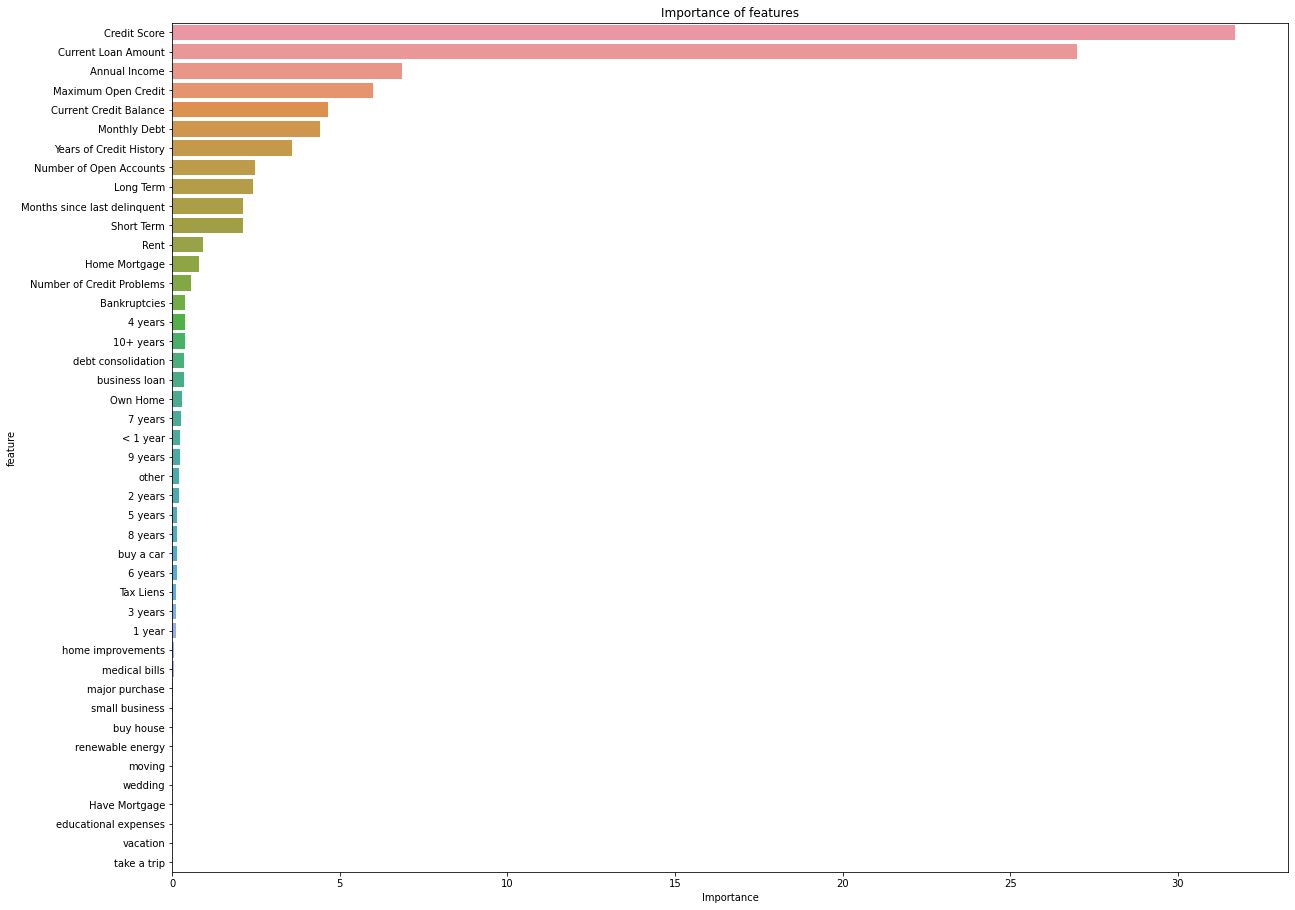

In [70]:
important_features_top = show_feature_importances(X_train.columns, model_cat.feature_importances_, get_top=30)

In [71]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Monthly Debt',
 'Years of Credit History',
 'Number of Open Accounts',
 'Long Term',
 'Months since last delinquent',
 'Short Term',
 'Rent',
 'Home Mortgage',
 'Number of Credit Problems',
 'Bankruptcies',
 '4 years',
 '10+ years',
 'debt consolidation',
 'business loan',
 'Own Home',
 '7 years',
 '< 1 year',
 '9 years',
 'other',
 '2 years',
 '5 years',
 '8 years',
 'buy a car',
 '6 years',
 'Tax Liens']

### Финальная модель<a class="anchor" id="final_model"></a>

In [72]:
final_model = catb.CatBoostClassifier(n_estimators=500, 
                                      max_depth=6,
                                      l2_leaf_reg=10,
                                      class_weights=[1, 2],
                                      silent=True, random_state=13)

final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3708
           1       0.73      0.80      0.76      1683

    accuracy                           0.85      5391
   macro avg       0.82      0.83      0.83      5391
weighted avg       0.85      0.85      0.85      5391

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       918
           1       0.57      0.61      0.59       430

    accuracy                           0.73      1348
   macro avg       0.69      0.70      0.69      1348
weighted avg       0.73      0.73      0.73      1348

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               721  197
1               168  262


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [73]:
with open(MODELS_PATH / 'model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

## Рассчитываем тестовые данные

In [74]:
df_test=pd.read_csv(TEST_DATASET_PATH, sep=',')

In [75]:
df_test = fill_means (df_test, NUM_FEATURE_NAMES_WITH_PASS)
df_test = fill_dummies(df_test, CAT_FEATURE_NAMES)

Значения NA заменены средними по колонке 
Категориальные признаки разложены на dummy значения и удалены из df


In [76]:
X_test = df_test
y_test = final_model.predict(X_test[important_features_top])

In [77]:
df_test_submission = pd.concat([pd.DataFrame({'Id':X_test.index}), pd.DataFrame({'Credit Default':y_test})], axis=1)

# сохраняем в файл
df_test_submission.to_csv(SUBMISSON_DATASET_PATH, index=False, encoding='utf-8', sep=',')

In [78]:
df_test_submission.sample(5)

,Id,Credit Default
1937,1937,0
1608,1608,0
2232,2232,1
1107,1107,1
1933,1933,1


In [79]:
import sklearn
print(sklearn.__version__)

0.24.2


In [80]:
#pip freeze

argon2-cffi==20.1.0
async-generator==1.10
attrs==21.2.0
backcall==0.2.0
bleach==3.3.0
catboost==0.25.1
cffi==1.14.5
click==7.1.2
cloudpickle==1.6.0
colorama==0.4.4
cycler==0.10.0
dask==2021.4.1
dask-glm==0.2.0
dask-ml==1.9.0
decorator==5.0.7
defusedxml==0.7.1
distributed==2021.4.1
entrypoints==0.3
fsspec==2021.4.0
graphviz==0.16
HeapDict==1.0.1
imbalanced-learn==0.8.0
imblearn==0.0
ipykernel==5.5.4
ipython==7.23.1
ipython-genutils==0.2.0
jedi==0.18.0
Jinja2==2.11.3
joblib==1.0.1
jsonschema==3.2.0
jupyter-client==6.1.12
jupyter-core==4.7.1
jupyter-http-over-ws==0.0.8
jupyterlab-pygments==0.1.2
kiwisolver==1.3.1
lightgbm==3.2.1
llvmlite==0.36.0
locket==0.2.1
MarkupSafe==1.1.1
matplotlib==3.4.2
matplotlib-inline==0.1.2
mistune==0.8.4
msgpack==1.0.2
multipledispatch==0.6.0
nbclient==0.5.3
nbconvert==6.0.7
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.3.0
numba==0.53.1
numpy==1.20.3
packaging==20.9
pandas==1.2.4
pandocfilters==1.4.3
parso==0.8.2
partd==1.2.0
pickleshare==0.7.5
Pillow==8.2